In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
import re

#importing NLP Libraries

import nltk
from nltk.corpus import stopwords
# stopwords = stopwords.words('english')
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer #for creating Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

print(f'Succesfully imported all the above libraries')

Succesfully imported all the above libraries


### About the Data

This is the sentiment140 dataset.
It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 2 = neutral, 4 = positive) and they can be used to detect sentiment .
It contains the following 6 fields:

- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
+ ids: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)



In [2]:
twitter=pd.read_csv("twitter reviews.csv",header=None,encoding='latin-1')
twitter.head(10)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [3]:
twitter.columns=["target","ids","date","flag","user","text"]

In [5]:
twitter.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
print(f"No. of Rows: {twitter.shape[0]}\nNo. of columns:{twitter.shape[1]}")

No. of Rows: 1600000
No. of columns:6


In [ ]:
twitter.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [4]:
twitter["target"]=np.where(twitter["target"]==4,1,0)
twitter.target.value_counts()

1    800000
0    800000
Name: target, dtype: int64

In [ ]:
# print("No. of Rows: %d\nNo. of columns: %d" %(twitter.shape[0],twitter.shape[1]))

For instance lets convert the supervised data into unsupervised data, so that lets drop the target column and process the unsupervised techniques like (TextBlob, IBM Watson,NLTK VADER) to predict the ploarity (target) variables

In [ ]:
!pip install watson_developer_cloud

     |████████████████████████████████| 256kB 9.5MB/s 
     |████████████████████████████████| 204kB 19.9MB/s 
  Created wheel for watson-developer-cloud: filename=watson_developer_cloud-2.10.1-cp36-none-any.whl size=252813 sha256=bf392e7e1f4b534442bcd4fa8c2615c04fbc29b1ddf51898a81c2971a2798eba
  Stored in directory: /root/.cache/pip/wheels/ea/a7/19/fac0a408a586265eb374005308a7553d4494ab41b2fd88f5bc
Successfully built watson-developer-cloud


In [ ]:
twitter.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [5]:
#since we donot need some columns, so we need to drop those unnecessary cols and proceed further process
df=twitter.drop(["ids","date","flag","user"],1)
df.columns

Index(['target', 'text'], dtype='object')

In [ ]:
user_text=df.text #lets divide the target and text columns 

### For Reference of UNSUPERVISED ALGORITHMS FOR NLP please check out the given URL:https://medium.com/@Intellica.AI/vader-ibm-watson-or-textblob-which-is-better-for-unsupervised-sentiment-analysis-db4143a39445

In [ ]:
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions, SentimentOptions, CategoriesOptions
natural_language_understanding = NaturalLanguageUnderstandingV1(                                         
    version='2018-11-16',
    iam_apikey= "i-IldqzZM-bX1sZIKOh86ZMO6BuU-Cpc9di56sjVhIDi", # Use your API key here
    url= "https://api.eu-gb.natural-language-understanding.watson.cloud.ibm.com/instances/45942d82-3fc8-44ef-8bb8-45ec67703e60" # paste the url here
    )
def Sentiment_score(input_text): 
    # Input text can be sentence, paragraph or document
    response = natural_language_understanding.analyze (
    text = input_text,
    features = Features(sentiment=SentimentOptions())).get_result()
    # From the response extract score which is between -1 to 1
    res = response.get('sentiment').get('document').get('score')
    return res

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: watson-developer-cloud moved to ibm-watson. To get updates, use the new package.
  


In [ ]:
target_column1=user_text[0:6].map(lambda x: Sentiment_score(x))

In [ ]:
target_column1 #Since IBM Watson is not an open source library, As IBM Watson is only applicable to process for 15000 character only) 

0   -0.399120
1   -0.988229
2   -0.663827
3   -0.836451
4   -0.942761
5   -0.743426
Name: text, dtype: float64

- To gauge the results, you will have to keep looking at the score that is returned as a result. If the score is greater than 0, then the sentiment is considered to be positive, else negative.

##### Lets go for "TextBlob" which is an unsupervised algorithm to find the target columns or polarities

TextBlob is a Python-based open source library that can be used to perform sentiment analysis effectively

In [ ]:
# !pip install textblob

In [ ]:
from textblob import TextBlob
# Get the polarity score using below function
def get_textBlob_score(sent):
    # This polarity score is between -1 to 1
    polarity = TextBlob(sent).sentiment.polarity
    return polarity

In [ ]:
target_column2=user_text.map(lambda x: get_textBlob_score(x))
target_column2=np.array(target_column2)


array([0.21666667, 0.        , 0.5       , ..., 0.2       , 1.        ,
       0.8       ])

In [ ]:
cond=[target_column2>=0,target_column2<0]
choice=[1,0]
target_column2=np.select(cond,choice)
target_column2

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from mlxtend.evaluate import confusion_matrix

In [ ]:
accuracy_score(twitter["target"],target_column2)

0.6089525

In [ ]:
#plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="right",
                 color="White" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


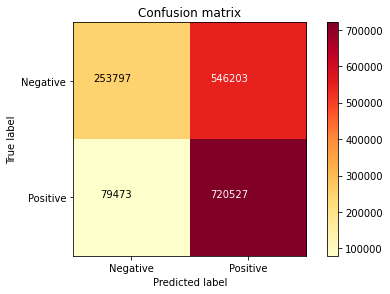

In [ ]:
import itertools
cm = confusion_matrix(twitter["target"],target_column2)
plot_confusion_matrix(cm, classes=['Negative', 'Positive'])
plt.savefig("confusion_matrix.jpg")

- TextBlob’s sentiment function returns tuple, polarity, and subjectivity and the polarity score floats within the range of -1.0 & 1.0 where anything greater than 0 is positive and below 0 is negative.

NLTK VADER

VADER or Valence Aware Dictionary and Sentiment Reasoner is a rule/lexicon-based, open-source sentiment analyzer pre-built library, protected under the MIT license

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
  l=[]
    # Polarity score returns dictionary
  ss = sid.polarity_scores(sent)
  # print(ss)
  value=sorted(ss,key= ss.get, reverse=True)[0]
  # print(value)
  # print('\n')
  # l.append(value)
    
  return value

    # for k in sorted(ss):
    #     print('{0}: {1}, '.format(k, ss[k]), end='')
    #     print()

In [ ]:
target_column3=user_text.map(lambda x: get_vader_score(x))
target_column3

0               neu
1               neu
2               neu
3               neu
4               neu
             ...   
1599995    compound
1599996         neu
1599997         neu
1599998         neu
1599999    compound
Name: text, Length: 1600000, dtype: object

In [ ]:
t=pd.DataFrame(data=list(target_column3),columns=["target_column3"])
t.head()

,target_column3
0,neu
1,neu
2,neu
3,neu
4,neu


In [ ]:
cond=[t["target_column3"]=="compound",t["target_column3"]=="neg",t["target_column3"]=="neu",t["target_column3"]=="pos"]
ans=[3,2,0,1]
target_column3=np.select(cond,ans)
target_column3

array([0, 0, 0, ..., 0, 0, 3])

In [ ]:
t.target_column3.value_counts()

neu         1247530
compound     270277
neg           47105
pos           35088
Name: target_column3, dtype: int64

#### Data Preprocessing

In [6]:
df.text

0          @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          is upset that he can't update his Facebook by ...
2          @Kenichan I dived many times for the ball. Man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: text, Length: 1600000, dtype: object

In [7]:
#importing libraries
from  nltk.stem import SnowballStemmer
import string
nltk.download('stopwords')
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [44]:
### CLEANING THE CORPUS

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
 
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'\$\w*', '', text)
    # remove old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'[#@]+', '', text)


    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(text)

    tweets_clean = []
    
    text = [stemmer.stem(word) for word in tweet_tokens if word not in set(stopwords.words('english'))]
    text = ' '.join(text)
    # tr(tweets_clean.append(text))
    

    
    return text

In [7]:
negative=df[df.target==0][0:15]
positive=df[df.target==1][0:15]
df1=pd.concat([negative,positive],axis=0,join="outer").iloc[:,[0,1]]

df1.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [8]:
df1.reset_index(inplace=True,drop=True)

In [9]:
df1.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [10]:
df1.shape


(30, 2)

In [16]:
df1.isnull().any()

target    False
text      False
dtype: bool

In [50]:
df1["clean_text"]=df1["text"].map(lambda x:cleantext(x))

In [51]:
df1.head()

,target,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww that bummer shoulda got david ...
1,0,is upset that he can't update his Facebook by ...,upset cant updat facebook text might cri resul...
2,0,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",nationwideclass behav im mad cant see


In [48]:
df1.to_csv("twitter.csv")

In [10]:
from utils.data_preprocess import cleantext #mylibrary

[nltk_data] Downloading package stopwords to C:\Users\Praveen
[nltk_data]     Bhargav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1]:

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from  nltk.stem import SnowballStemmer
import string





### CLEANING THE CORPUS

def cleantext(data,column):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    stem=str(input("Enter what type of stemmer you need to apply to text:")).strip()
    
    if stem =="PorterStemmer":
        stemmer = PorterStemmer()
        tweets_clean = []
        for i in data[column]:
            i = str(i).lower()
            i = re.sub('\[.*?\]', '', i)
            i = re.sub('https?://\S+|www\.\S+', '', i)
            i = re.sub('<.*?>+', '', i)
            i = re.sub('[%s]' % re.escape(string.punctuation), '', i)
            i = re.sub('\n', '', i)
            i = re.sub('\w*\d\w*', '', i)
            i = re.sub(r'\$\w*', '', i)
            # remove old style retweet text "RT"
            i = re.sub(r'^RT[\s]+', '', i)
            # remove hyperlinks
            i = re.sub(r'https?:\/\/.*[\r\n]*', '', i)
            # remove hashtags
            # only removing the hash # sign from the word
            i = re.sub(r'[#@]+', '', i)
    
    
            tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                                       reduce_len=True)
            tweet_tokens = tokenizer.tokenize(i)
        
            
            
            text = [stemmer.stem(word) for word in tweet_tokens if word not in set(stopwords.words('english'))]
            text = ' '.join(text)
            tweets_clean.append(text)
    

    
        return tweets_clean
    
    
    elif stem =="SnowballStemmer":
        stemmer = SnowballStemmer("english")
        tweets_clean = []
        for i in data[column]:
            i = str(i).lower()
            i = re.sub('\[.*?\]', '', i)
            i = re.sub('https?://\S+|www\.\S+', '', i)
            i = re.sub('<.*?>+', '', i)
            i = re.sub('[%s]' % re.escape(string.punctuation), '', i)
            i = re.sub('\n', '', i)
            i = re.sub('\w*\d\w*', '', i)
            i = re.sub(r'\$\w*', '', i)
            # remove old style retweet text "RT"
            i = re.sub(r'^RT[\s]+', '', i)
            # remove hyperlinks
            i = re.sub(r'https?:\/\/.*[\r\n]*', '', i)
            # remove hashtags
            # only removing the hash # sign from the word
            i = re.sub(r'[#@]+', '', i)
    
    
            tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                                       reduce_len=True)
            tweet_tokens = tokenizer.tokenize(i)
        
            
            
            text = [stemmer.stem(word) for word in tweet_tokens if word not in set(stopwords.words('english'))]
            text = ' '.join(text)
            tweets_clean.append(text)
    

    
        return tweets_clean
    
    elif stem =="WordNetLemmatizer":
        stemmer = WordNetLemmatizer()
        tweets_clean = []
        for i in data[column]:
            i = str(i).lower()
            i = re.sub('\[.*?\]', '', i)
            i = re.sub('https?://\S+|www\.\S+', '', i)
            i = re.sub('<.*?>+', '', i)
            i = re.sub('[%s]' % re.escape(string.punctuation), '', i)
            i = re.sub('\n', '', i)
            i = re.sub('\w*\d\w*', '', i)
            i = re.sub(r'\$\w*', '', i)
            # remove old style retweet text "RT"
            i = re.sub(r'^RT[\s]+', '', i)
            # remove hyperlinks
            i = re.sub(r'https?:\/\/.*[\r\n]*', '', i)
            # remove hashtags
            # only removing the hash # sign from the word
            i = re.sub(r'[#@]+', '', i)
    
    
            tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                                       reduce_len=True)
            tweet_tokens = tokenizer.tokenize(i)
        
            
            
            text = [stemmer.lemmatize(word) for word in tweet_tokens if word not in set(stopwords.words('english'))]
            text = ' '.join(text)
            tweets_clean.append(text)
    

    
        return tweets_clean
    
    else:
        print("Your desired stemmer is not in the dictionary:PorterStemmer,WordNetLemmatizer,SnowballStemmer\nPlease check and try with the given stemmers only")
        
    

[nltk_data] Downloading package stopwords to C:\Users\Praveen
[nltk_data]     Bhargav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df1["cleandfdfdfdf"]=cleantext(df1,"text")

NameError: name 'df1' is not defined

In [12]:
df1.head()

,target,text,cleandfdfdfdf
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww that bummer shoulda got david ...
1,0,is upset that he can't update his Facebook by ...,upset cant updat facebook text might cri resul...
2,0,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",nationwideclass behav im mad cant see
